Model and scaler saved!
Confusion Matrix:
 [[900  74]
 [  0  26]]

Accuracy: 0.93

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96       974
           1       0.26      1.00      0.41        26

    accuracy                           0.93      1000
   macro avg       0.63      0.96      0.69      1000
weighted avg       0.98      0.93      0.95      1000


Precision-Recall AUC: 0.63


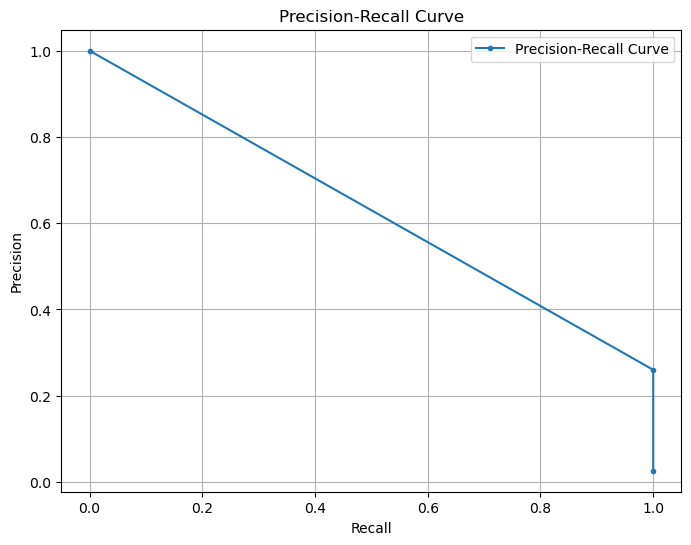


ROC-AUC: 0.96


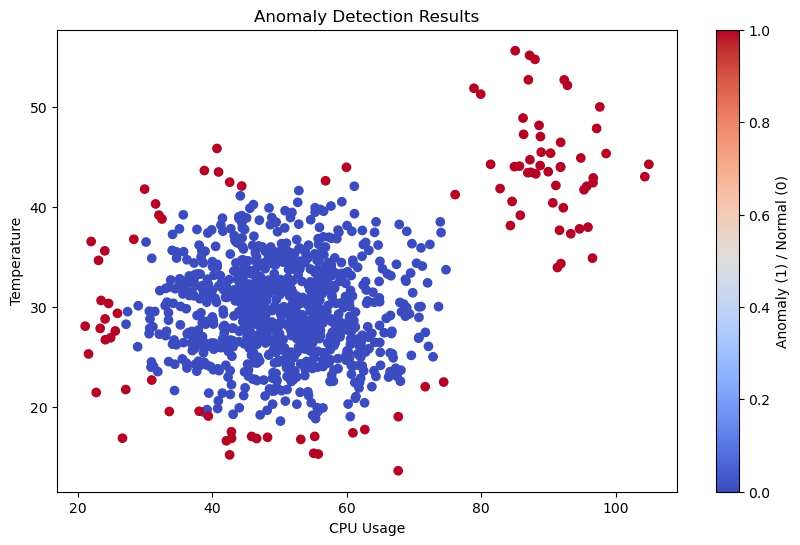

In [9]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc
)
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('synthetic_anomaly_data.csv')

# Select features
X = df[['cpu_usage', 'temperature']]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest model with tuned parameters
model = IsolationForest(
    contamination=0.1,  # Approximate percentage of anomalies in the dataset
    n_estimators=200,   # Increase number of trees
    max_samples=256,    # Use a larger subsample size
    random_state=42
)
model.fit(X_scaled)

# Save the model and scaler
joblib.dump(model, 'models/anomaly_detection.pkl')
joblib.dump(scaler, 'models/scaler.pkl')

print("Model and scaler saved!")

# Predict anomaly labels for the dataset
y_pred = model.predict(X_scaled)

# Anomaly prediction: 1 means normal, -1 means anomaly
# Convert the predictions into binary format: 0 for normal, 1 for anomaly
y_pred_binary = np.where(y_pred == -1, 1, 0)

# Ensure true anomalies exist (synthetic example)
# Let's assume anomalies are marked where CPU usage is > 90 or temperature > 75
anomaly_condition = (df['cpu_usage'] > 90) | (df['temperature'] > 75)
df['true_labels'] = np.where(anomaly_condition, 1, 0)

# Add distinct synthetic anomalies if none exist
if df['true_labels'].sum() == 0:
    print("No anomalies found, adding synthetic anomalies...")
    # Create synthetic anomalies with extreme values
    for _ in range(100):  # Add 100 synthetic anomalies
        synthetic_anomaly = {
            'cpu_usage': np.random.uniform(90, 100),  # High CPU usage
            'temperature': np.random.uniform(75, 100)  # High temperature
        }
        df = pd.concat([df, pd.DataFrame([synthetic_anomaly])], ignore_index=True)
    df['true_labels'] = np.where((df['cpu_usage'] > 90) | (df['temperature'] > 75), 1, 0)

# Evaluate performance
y_true = df['true_labels']

# Check if both classes are present in the true labels
if len(np.unique(y_true)) > 1:
    # Confusion Matrix
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_binary))
    
    # Accuracy Score
    accuracy = accuracy_score(y_true, y_pred_binary)
    print(f"\nAccuracy: {accuracy:.2f}")
    
    # Classification Report with zero_division=1 to avoid undefined metrics
    print("\nClassification Report:\n", classification_report(y_true, y_pred_binary, zero_division=1))
    
    # Precision-Recall Curve for imbalanced datasets
    precision, recall, _ = precision_recall_curve(y_true, y_pred_binary)
    pr_auc = auc(recall, precision)
    print(f"\nPrecision-Recall AUC: {pr_auc:.2f}")

    # Plot Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # ROC-AUC Score
    try:
        roc_auc = roc_auc_score(y_true, y_pred_binary)
        print(f"\nROC-AUC: {roc_auc:.2f}")
    except ValueError:
        print("\nROC-AUC cannot be computed because only one class is present in y_true.")
else:
    print("\nTrue labels contain only one class, skipping metrics.")

# Visualizing anomalies (Optional, for better understanding)
df['anomaly'] = y_pred_binary
plt.figure(figsize=(10, 6))
plt.scatter(df['cpu_usage'], df['temperature'], c=df['anomaly'], cmap='coolwarm', marker='o')
plt.xlabel('CPU Usage')
plt.ylabel('Temperature')
plt.title('Anomaly Detection Results')
plt.colorbar(label='Anomaly (1) / Normal (0)')
plt.show()


Actual correlation between CPU usage and temperature: 0.71


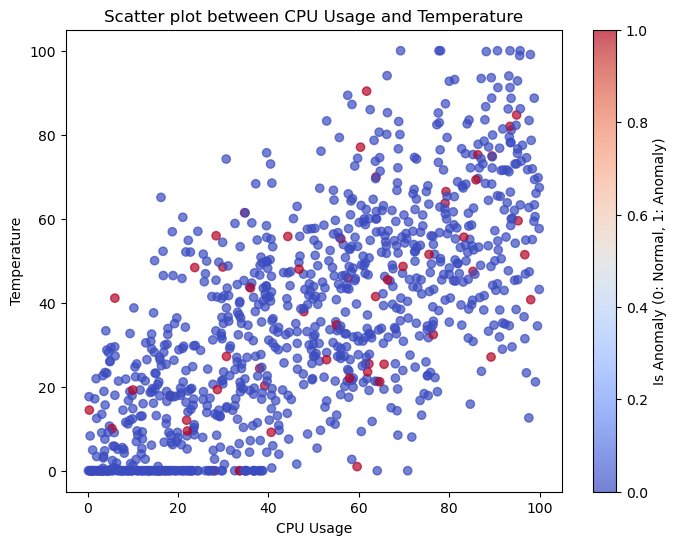

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generate_synthetic_data(n_samples=1000, correlation_target=0.7, noise_factor=30):
    # Generate CPU usage as a random feature
    cpu_usage = np.random.uniform(0, 100, size=n_samples)

    # Create temperature highly correlated with cpu_usage, but with added noise
    # We control the correlation by mixing cpu_usage with some random noise
    random_noise = np.random.normal(0, noise_factor, size=n_samples)
    temperature = cpu_usage * correlation_target + random_noise  # Added noise factor

    # Ensure the temperature stays within a realistic range (e.g., between 0 and 100)
    temperature = np.clip(temperature, 0, 100)

    # Calculate the actual correlation
    actual_correlation = np.corrcoef(cpu_usage, temperature)[0, 1]

    # Adjust the noise_factor until the desired correlation is achieved
    while not (0.5 <= actual_correlation <= 0.9):
        random_noise = np.random.normal(0, noise_factor, size=n_samples)
        temperature = cpu_usage * correlation_target + random_noise
        temperature = np.clip(temperature, 0, 100)
        actual_correlation = np.corrcoef(cpu_usage, temperature)[0, 1]

        if actual_correlation > 0.9:
            noise_factor += 5
        elif actual_correlation < 0.5:
            noise_factor -= 5

    # Create anomalies randomly (binary classification: 0 for normal, 1 for anomaly)
    is_anomaly = np.random.choice([0, 1], size=n_samples, p=[0.95, 0.05])  # 5% anomalies for example

    # Create a DataFrame
    df = pd.DataFrame({
        'cpu_usage': cpu_usage,
        'temperature': temperature,
        'is_anomaly': is_anomaly
    })
    
    return df, actual_correlation

# Generate synthetic data with the target correlation between CPU usage and temperature
df, correlation = generate_synthetic_data(n_samples=1000, correlation_target=0.7, noise_factor=20)

# Print actual correlation
print(f"Actual correlation between CPU usage and temperature: {correlation:.2f}")

# Visualize the data and correlation
plt.figure(figsize=(8, 6))
plt.scatter(df['cpu_usage'], df['temperature'], c=df['is_anomaly'], cmap='coolwarm', alpha=0.7)
plt.title("Scatter plot between CPU Usage and Temperature")
plt.xlabel("CPU Usage")
plt.ylabel("Temperature")
plt.colorbar(label="Is Anomaly (0: Normal, 1: Anomaly)")
plt.show()


Model and scaler saved!
Training Accuracy: 0.93
Testing Accuracy: 0.92

Confusion Matrix (Test Data):
 [[178  17]
 [  0   5]]

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       1.00      0.91      0.95       195
           1       0.23      1.00      0.37         5

    accuracy                           0.92       200
   macro avg       0.61      0.96      0.66       200
weighted avg       0.98      0.92      0.94       200


Precision-Recall AUC (Test Data): 0.61


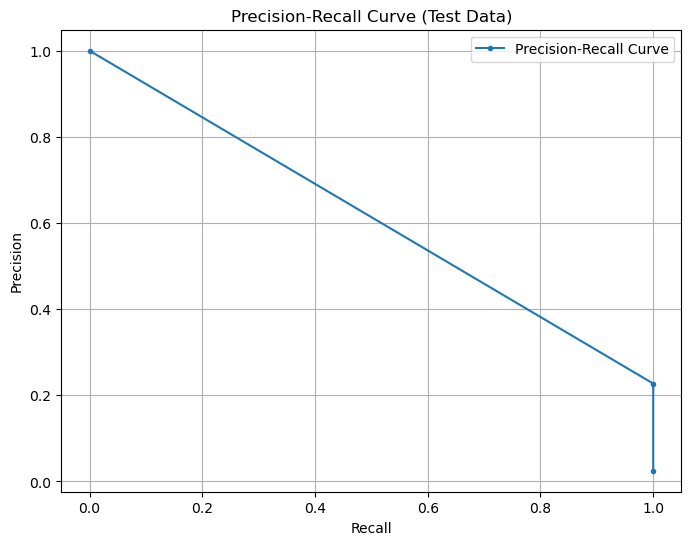

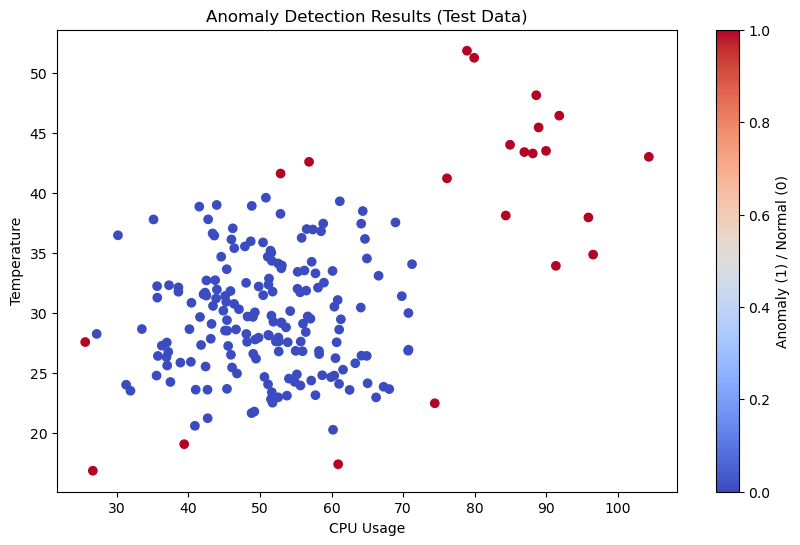

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

# Load dataset
df = pd.read_csv('synthetic_anomaly_data.csv')

# Select features
X = df[['cpu_usage', 'temperature']]
y = np.where((df['cpu_usage'] > 90) | (df['temperature'] > 75), 1, 0)  # True labels (0: normal, 1: anomaly)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Isolation Forest model
model = IsolationForest(
    contamination=0.1,  # Approximate percentage of anomalies in the dataset
    n_estimators=200,   # Increase number of trees
    max_samples=256,    # Use a larger subsample size
    random_state=42
)
model.fit(X_train_scaled)

# Save the model and scaler
joblib.dump(model, 'models/anomaly_detection.pkl')
joblib.dump(scaler, 'models/scaler.pkl')

print("Model and scaler saved!")

# Predict on training and testing data
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Convert predictions to binary format: 0 for normal, 1 for anomaly
y_train_pred_binary = np.where(y_train_pred == -1, 1, 0)
y_test_pred_binary = np.where(y_test_pred == -1, 1, 0)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Calculate testing accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
print(f"Testing Accuracy: {test_accuracy:.2f}")

# Evaluate on testing data
print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_pred_binary))
print("\nClassification Report (Test Data):\n", classification_report(y_test, y_test_pred_binary, zero_division=1))

# Precision-Recall Curve for test data
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_binary)
pr_auc = auc(recall, precision)
print(f"\nPrecision-Recall AUC (Test Data): {pr_auc:.2f}")

# Plot Precision-Recall Curve for test data
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Test Data)')
plt.legend()
plt.grid()
plt.show()

# Visualizing anomalies in test data
plt.figure(figsize=(10, 6))
plt.scatter(X_test['cpu_usage'], X_test['temperature'], c=y_test_pred_binary, cmap='coolwarm', marker='o')
plt.xlabel('CPU Usage')
plt.ylabel('Temperature')
plt.title('Anomaly Detection Results (Test Data)')
plt.colorbar(label='Anomaly (1) / Normal (0)')
plt.show()


In [14]:
# Extract information about the trees in the Isolation Forest
n_trees = len(model.estimators_)  # Number of trees in the Isolation Forest
print(f"Number of trees in the Isolation Forest: {n_trees}")

# Iterate through each tree to get the number of nodes and leaf nodes
for i, tree in enumerate(model.estimators_):
    n_nodes = tree.tree_.node_count  # Total number of nodes in the tree
    n_leaf_nodes = tree.tree_.n_leaves  # Number of leaf nodes in the tree
    print(f"Tree {i+1}:")
    print(f"  Number of nodes: {n_nodes}")
    print(f"  Number of leaf nodes: {n_leaf_nodes}")


Number of trees in the Isolation Forest: 200
Tree 1:
  Number of nodes: 195
  Number of leaf nodes: 98
Tree 2:
  Number of nodes: 143
  Number of leaf nodes: 72
Tree 3:
  Number of nodes: 147
  Number of leaf nodes: 74
Tree 4:
  Number of nodes: 147
  Number of leaf nodes: 74
Tree 5:
  Number of nodes: 153
  Number of leaf nodes: 77
Tree 6:
  Number of nodes: 71
  Number of leaf nodes: 36
Tree 7:
  Number of nodes: 85
  Number of leaf nodes: 43
Tree 8:
  Number of nodes: 185
  Number of leaf nodes: 93
Tree 9:
  Number of nodes: 119
  Number of leaf nodes: 60
Tree 10:
  Number of nodes: 87
  Number of leaf nodes: 44
Tree 11:
  Number of nodes: 137
  Number of leaf nodes: 69
Tree 12:
  Number of nodes: 155
  Number of leaf nodes: 78
Tree 13:
  Number of nodes: 183
  Number of leaf nodes: 92
Tree 14:
  Number of nodes: 147
  Number of leaf nodes: 74
Tree 15:
  Number of nodes: 99
  Number of leaf nodes: 50
Tree 16:
  Number of nodes: 137
  Number of leaf nodes: 69
Tree 17:
  Number of nod

In [15]:
# Initialize counters for total nodes and leaf nodes
total_nodes = 0
total_leaf_nodes = 0
n_trees = len(model.estimators_)  # Number of trees in the Isolation Forest

# Iterate through each tree to accumulate node and leaf counts
for tree in model.estimators_:
    total_nodes += tree.tree_.node_count  # Add the number of nodes in the tree
    total_leaf_nodes += tree.tree_.n_leaves  # Add the number of leaf nodes in the tree

# Calculate averages
average_nodes = total_nodes / n_trees
average_leaf_nodes = total_leaf_nodes / n_trees

print(f"Average number of nodes per tree: {average_nodes:.2f}")
print(f"Average number of leaf nodes per tree: {average_leaf_nodes:.2f}")


Average number of nodes per tree: 129.97
Average number of leaf nodes per tree: 65.48


Model and scaler with 100 trees saved!
Training Accuracy: 0.93
Testing Accuracy: 0.91

Confusion Matrix (Test Data):
 [[177  18]
 [  0   5]]

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       1.00      0.91      0.95       195
           1       0.22      1.00      0.36         5

    accuracy                           0.91       200
   macro avg       0.61      0.95      0.65       200
weighted avg       0.98      0.91      0.94       200



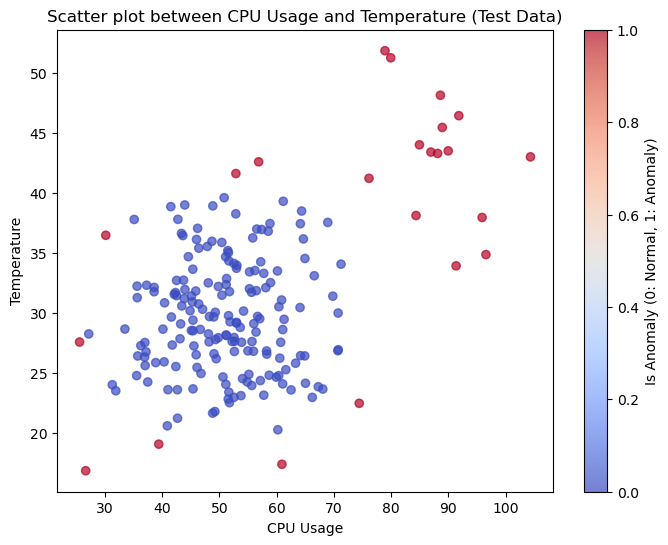

In [16]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv('synthetic_anomaly_data.csv')

# Select features
X = df[['cpu_usage', 'temperature']]
y = np.where((df['cpu_usage'] > 90) | (df['temperature'] > 75), 1, 0)  # True labels (0: normal, 1: anomaly)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Isolation Forest model with 100 trees
model = IsolationForest(
    contamination=0.1,  # Approximate percentage of anomalies in the dataset
    n_estimators=100,   # Reduce number of trees to 100
    max_samples=256,    # Use a larger subsample size
    random_state=42
)
model.fit(X_train_scaled)

# Save the model and scaler
joblib.dump(model, 'models/anomaly_detection_100_trees.pkl')
joblib.dump(scaler, 'models/scaler.pkl')

print("Model and scaler with 100 trees saved!")

# Predict on training and testing data
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Convert predictions to binary format: 0 for normal, 1 for anomaly
y_train_pred_binary = np.where(y_train_pred == -1, 1, 0)
y_test_pred_binary = np.where(y_test_pred == -1, 1, 0)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Calculate testing accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
print(f"Testing Accuracy: {test_accuracy:.2f}")

# Evaluate on testing data
print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_pred_binary))
print("\nClassification Report (Test Data):\n", classification_report(y_test, y_test_pred_binary, zero_division=1))

# Visualize the data and correlation
plt.figure(figsize=(8, 6))
plt.scatter(X_test['cpu_usage'], X_test['temperature'], c=y_test_pred_binary, cmap='coolwarm', alpha=0.7)
plt.title("Scatter plot between CPU Usage and Temperature (Test Data)")
plt.xlabel("CPU Usage")
plt.ylabel("Temperature")
plt.colorbar(label="Is Anomaly (0: Normal, 1: Anomaly)")
plt.show()



In [17]:
# Get the number of trees in the trained Isolation Forest model
num_trees = len(model.estimators_)
print(f"Number of trees in the model: {num_trees}")


Number of trees in the model: 100


In [ ]:
# Use fixed-point arithmetic instead of floating-point for feature thresholds and comparison logic.

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset (example)
df = pd.read_csv('synthetic_anomaly_data.csv')

# Select features
X = df[['cpu_usage', 'temperature']]

# Define a scaling factor for fixed-point representation
scaling_factor = 1000  # Scale by 1000 for 3 decimal places of precision

# Convert features to fixed-point by scaling them (multiply by scaling factor)
X_fixed_point = (X * scaling_factor).astype(int)

# True labels (1: anomaly, 0: normal)
y = np.where((df['cpu_usage'] > 90) | (df['temperature'] > 75), 1, 0)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_fixed_point, y, test_size=0.2, random_state=42, stratify=y)

# Scale features for model training (Normalization of fixed-point data is typically required)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Isolation Forest model
model = IsolationForest(
    contamination=0.1,
    n_estimators=100,  # Reduce number of trees to 100
    max_samples=256,
    random_state=42
)
model.fit(X_train_scaled)

# Predict on training and testing data
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Convert predictions to binary format: 0 for normal, 1 for anomaly
y_train_pred_binary = np.where(y_train_pred == -1, 1, 0)
y_test_pred_binary = np.where(y_test_pred == -1, 1, 0)

# Calculate training and testing accuracy
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
print(f"Training Accuracy: {train_accuracy:.2f}")

test_accuracy = accuracy_score(y_test, y_test_pred_binary)
print(f"Testing Accuracy: {test_accuracy:.2f}")

# Evaluate on testing data
print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_pred_binary))
print("\nClassification Report (Test Data):\n", classification_report(y_test, y_test_pred_binary))



Training Accuracy: 0.93
Testing Accuracy: 0.91

Confusion Matrix (Test Data):
 [[177  18]
 [  0   5]]

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       1.00      0.91      0.95       195
           1       0.22      1.00      0.36         5

    accuracy                           0.91       200
   macro avg       0.61      0.95      0.65       200
weighted avg       0.98      0.91      0.94       200

